Loading dataset...
Combined dataset shape: (3672151, 7)

Preprocessing data...
Removed 0 duplicate rows. Shape after: (3672151, 7)

Overall Class Distribution:
Label
Normal    3372743
Attack     299408
Name: count, dtype: int64

Training model...

Training set shape: (2937720, 11) (80.00% of total)
Test set shape: (734431, 11) (20.00% of total)

Training set class distribution:
Label
Normal    2698194
Attack     239526
Name: count, dtype: int64

Test set class distribution:
Label
Normal    674549
Attack     59882
Name: count, dtype: int64


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:42:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Training Accuracy: 0.9951
Test Accuracy: 0.9950

Classification Report (Test Set):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    674549
      Attack       0.98      0.95      0.97     59882

    accuracy                           0.99    734431
   macro avg       0.99      0.98      0.98    734431
weighted avg       0.99      0.99      0.99    734431



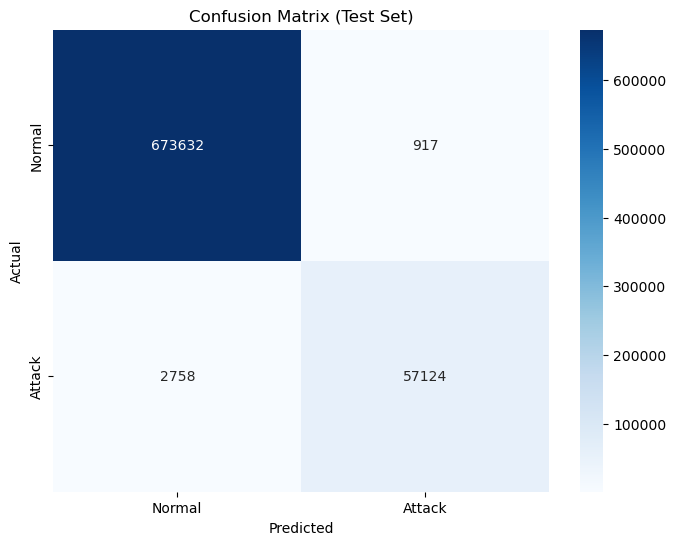

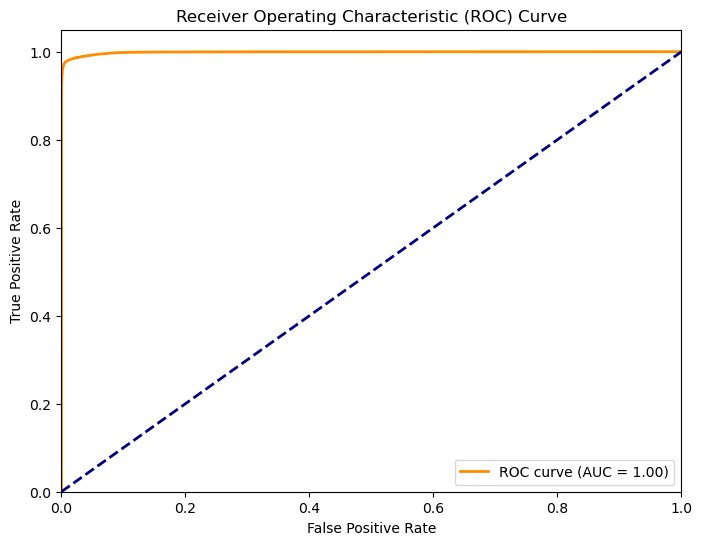

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define the dataset directory
directory = "/Users/bodapati/Downloads/Car_Hacking_Challenge_Dataset_rev20Mar2021/0_Preliminary/0_Training"

# Step 2: Load and merge all CSV files
def load_and_merge_files(dir_path):
    all_dfs = []
    for filename in os.listdir(dir_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(dir_path, filename)
            try:
                df = pd.read_csv(file_path)
                df['File'] = filename  # Add file identifier for reference
                all_dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    if not all_dfs:
        raise ValueError("No CSV files found or all files failed to load.")
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined dataset shape: {combined_df.shape}")
    return combined_df

# Step 3: Preprocess the data
def preprocess_data(df):
    # Handle missing values (impute with mode for categorical, mean for numerical)
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    
    # Numerical columns
    num_cols = ['Timestamp', 'DLC']
    df[num_cols] = imputer_num.fit_transform(df[num_cols])
    
    # Categorical columns
    cat_cols = ['Arbitration_ID', 'Data', 'Class']
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
    
    # Remove duplicates
    initial_rows = df.shape[0]
    df = df.drop_duplicates()
    print(f"Removed {initial_rows - df.shape[0]} duplicate rows. Shape after: {df.shape}")
    
    # Parse Data field into individual bytes (assuming hex strings separated by space)
    def parse_data(data_str):
        try:
            bytes_list = data_str.strip().split()
            bytes_int = [int(b, 16) if b else 0 for b in bytes_list]
            while len(bytes_int) < 8:
                bytes_int.append(0)
            return bytes_int[:8]  # Truncate to 8 if longer
        except:
            return [0] * 8  # Return zeros if parsing fails
    
    data_bytes = df['Data'].apply(parse_data)
    data_bytes_df = pd.DataFrame(data_bytes.tolist(), columns=[f'Byte_{i+1}' for i in range(8)], index=df.index)
    df = pd.concat([df, data_bytes_df], axis=1)
    df.drop('Data', axis=1, inplace=True)  # Drop original Data column
    
    # Feature engineering: Time differences
    df.sort_values('Timestamp', inplace=True)
    df['Time_Diff'] = df['Timestamp'].diff().fillna(0)
    
    # Encode categorical features
    le_arb = LabelEncoder()
    df['Arbitration_ID_Encoded'] = le_arb.fit_transform(df['Arbitration_ID'])
    
    # Binary classification: Normal (0) vs Attack (1)
    df['Label'] = df['Class'].apply(lambda x: 0 if x.lower() == 'normal' else 1)
    
    # Drop unnecessary columns
    df.drop(['Timestamp', 'Arbitration_ID', 'Class', 'SubClass', 'File'], axis=1, errors='ignore', inplace=True)
    
    return df

# Step 4: Train and evaluate the model
def train_model(X, y):
    # Train-test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Print train and test shapes and percentages
    total_samples = len(X)
    print(f"\nTraining set shape: {X_train.shape} ({len(X_train)/total_samples*100:.2f}% of total)")
    print(f"Test set shape: {X_test.shape} ({len(X_test)/total_samples*100:.2f}% of total)")
    
    # Print class distribution in numbers
    print("\nTraining set class distribution:")
    print(pd.Series(y_train).value_counts().rename({0: 'Normal', 1: 'Attack'}))
    print("\nTest set class distribution:")
    print(pd.Series(y_test).value_counts().rename({0: 'Normal', 1: 'Attack'}))
    
    # Initialize and train XGBoost
    model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Train and test accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"\nTraining Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Attack']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()
    
    # ROC Curve
    y_test_prob = model.predict_proba(X_test)[:, 1]  # Probability for Attack class
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return model

# Main execution
if __name__ == "__main__":
    try:
        # Load data
        print("Loading dataset...")
        df = load_and_merge_files(directory)
        
        # Preprocess
        print("\nPreprocessing data...")
        df_processed = preprocess_data(df)
        
        # Check overall class distribution
        print("\nOverall Class Distribution:")
        print(df_processed['Label'].value_counts().rename({0: 'Normal', 1: 'Attack'}))
        
        # Features and labels
        X = df_processed.drop('Label', axis=1)
        y = df_processed['Label']
        
        # Train and evaluate
        print("\nTraining model...")
        ids_model = train_model(X, y)
        
    except Exception as e:
        print(f"An error occurred: {e}")

Loading dataset...
Combined dataset shape: (3672151, 7)

Preprocessing data...
Removed 0 duplicate rows. Shape after: (3672151, 7)

Class distribution in dataset:
SubClass
Normal      3372743
Flooding     154180
Fuzzing       89879
Replay        47593
Spoofing       7756
Name: count, dtype: int64

Overall Class Distribution:
Label
Normal      3372743
Flooding     154180
Fuzzing       89879
Replay        47593
Spoofing       7756
Name: count, dtype: int64

Training model...

Training set shape: (2937720, 11) (80.00% of total)
Test set shape: (734431, 11) (20.00% of total)

Training set class distribution:
Label
Normal      2698194
Flooding     123344
Fuzzing       71903
Replay        38074
Spoofing       6205
Name: count, dtype: int64

Test set class distribution:
Label
Normal      674549
Flooding     30836
Fuzzing      17976
Replay        9519
Spoofing      1551
Name: count, dtype: int64


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Training Accuracy: 0.9954
Test Accuracy: 0.9952

Classification Report (Test Set):
              precision    recall  f1-score   support

    Flooding       1.00      1.00      1.00     30836
     Fuzzing       1.00      1.00      1.00     17976
      Normal       1.00      1.00      1.00    674549
      Replay       0.89      0.72      0.80      9519
    Spoofing       1.00      1.00      1.00      1551

    accuracy                           1.00    734431
   macro avg       0.98      0.94      0.96    734431
weighted avg       0.99      1.00      1.00    734431



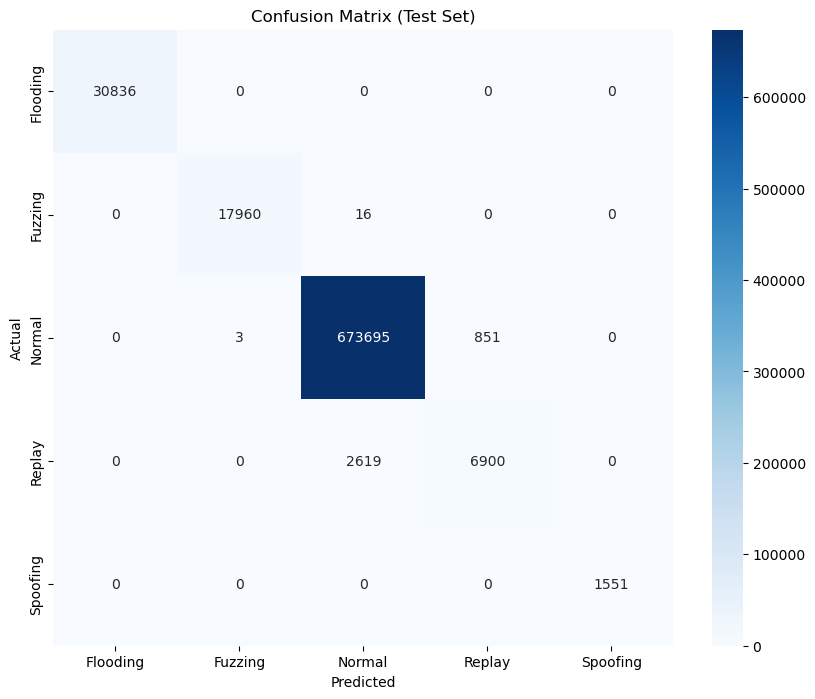

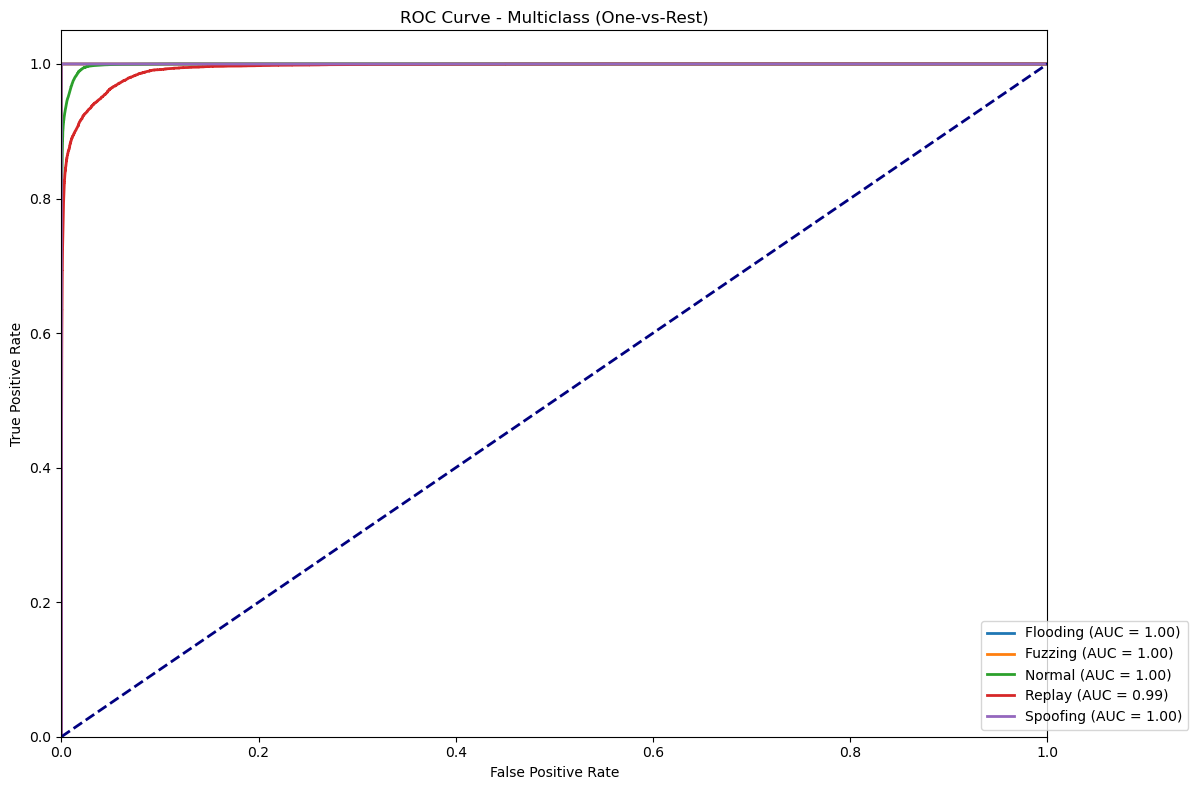


Macro-average ROC AUC: 0.9986


In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define the dataset directory
directory = "/Users/bodapati/Downloads/Car_Hacking_Challenge_Dataset_rev20Mar2021/0_Preliminary/0_Training"

# Step 2: Load and merge all CSV files
def load_and_merge_files(dir_path):
    all_dfs = []
    for filename in os.listdir(dir_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(dir_path, filename)
            try:
                df = pd.read_csv(file_path)
                df['File'] = filename  # Add file identifier for reference
                all_dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    if not all_dfs:
        raise ValueError("No CSV files found or all files failed to load.")
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined dataset shape: {combined_df.shape}")
    return combined_df

# Step 3: Preprocess the data
def preprocess_data(df):
    # Handle missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    
    # Numerical columns
    num_cols = ['Timestamp', 'DLC']
    df[num_cols] = imputer_num.fit_transform(df[num_cols])
    
    # Categorical columns
    cat_cols = ['Arbitration_ID', 'Data', 'Class', 'SubClass']
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
    
    # Remove duplicates
    initial_rows = df.shape[0]
    df = df.drop_duplicates()
    print(f"Removed {initial_rows - df.shape[0]} duplicate rows. Shape after: {df.shape}")
    
    # Parse Data field into individual bytes
    def parse_data(data_str):
        try:
            bytes_list = data_str.strip().split()
            bytes_int = [int(b, 16) if b else 0 for b in bytes_list]
            while len(bytes_int) < 8:
                bytes_int.append(0)
            return bytes_int[:8]
        except:
            return [0] * 8
    
    data_bytes = df['Data'].apply(parse_data)
    data_bytes_df = pd.DataFrame(data_bytes.tolist(), columns=[f'Byte_{i+1}' for i in range(8)], index=df.index)
    df = pd.concat([df, data_bytes_df], axis=1)
    df.drop('Data', axis=1, inplace=True)
    
    # Feature engineering: Time differences
    df.sort_values('Timestamp', inplace=True)
    df['Time_Diff'] = df['Timestamp'].diff().fillna(0)
    
    # Encode categorical features
    le_arb = LabelEncoder()
    df['Arbitration_ID_Encoded'] = le_arb.fit_transform(df['Arbitration_ID'])
    
    # Multiclass classification: Use SubClass as label
    le_label = LabelEncoder()
    df['Label'] = le_label.fit_transform(df['SubClass'])
    class_names = le_label.classes_
    
    # Check class distribution
    print("\nClass distribution in dataset:")
    class_counts = df['SubClass'].value_counts()
    print(class_counts)
    if any(class_counts < 10):
        print("Warning: Some classes have very few samples (<10), which may affect model performance.")
    
    # Drop unnecessary columns
    df.drop(['Timestamp', 'Arbitration_ID', 'Class', 'SubClass', 'File'], axis=1, errors='ignore', inplace=True)
    
    return df, class_names, le_label

# Step 4: Train and evaluate the model
def train_model(X, y, class_names):
    # Train-test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Ensure all classes appear in test set
    unique_classes_test = np.unique(y_test)
    if len(unique_classes_test) < len(class_names):
        print("Warning: Test set missing classes. Adjusting split...")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
        print(f"New test size: {len(X_test)} samples")
    
    # Print dataset info
    total_samples = len(X)
    print(f"\nTraining set shape: {X_train.shape} ({len(X_train)/total_samples*100:.2f}% of total)")
    print(f"Test set shape: {X_test.shape} ({len(X_test)/total_samples*100:.2f}% of total)")
    
    class_map = {i: class_names[i] for i in range(len(class_names))}
    print("\nTraining set class distribution:")
    print(pd.Series(y_train).map(class_map).value_counts())
    print("\nTest set class distribution:")
    print(pd.Series(y_test).map(class_map).value_counts())
    
    # Train XGBoost
    model = XGBClassifier(
        n_estimators=100,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=len(class_names)
    )
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Accuracy
    print(f"\nTraining Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    
    # Classification report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, target_names=class_names, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()
    
    # ROC Curve (One-vs-Rest)
    y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
    y_prob = model.predict_proba(X_test)
    
    plt.figure(figsize=(12, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        if len(y_test[y_test == i]) > 0:
            plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multiclass (One-vs-Rest)')
    plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0), ncol=1)
    plt.tight_layout()
    plt.show()
    
    # Macro-average ROC AUC
    macro_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
    print(f"\nMacro-average ROC AUC: {macro_auc:.4f}")
    
    return model

# Main execution
if __name__ == "__main__":
    try:
        print("Loading dataset...")
        df = load_and_merge_files(directory)
        
        print("\nPreprocessing data...")
        df_processed, class_names, le_label = preprocess_data(df)
        
        print("\nOverall Class Distribution:")
        class_map = {i: class_names[i] for i in range(len(class_names))}
        print(pd.Series(df_processed['Label']).map(class_map).value_counts())
        
        X = df_processed.drop('Label', axis=1)
        y = df_processed['Label']
        
        print("\nTraining model...")
        ids_model = train_model(X, y, class_names)
        
    except Exception as e:
        print(f"An error occurred: {e}")